<a href="https://colab.research.google.com/github/kurexi/fml-labs/blob/main/FML_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FML Lab 2
## Task 1.1: Data Generation and Closed-Form Ridge
1. Generate a synthetic regression dataset.

In [ ]:
from sklearn.datasets import make_regression
import numpy as np

X, y = make_regression(n_samples=100, n_features=10, noise=10, random_state=42)
X = np.column_stack((X, X[:,0]))

2. Implement the closed-form solution for Ridge regression to calculate the weight vector w.

In [ ]:
lambda_ = 1.0
n, d = X.shape

I = np.eye(d)
w_ridge_analytical = np.linalg.inv(X.T @ X + lambda_ * I) @ X.T @ y

3. Implement the Ridge Regression using gradient descent, and try different learning rates
and observe their convergence behaviours. Plot the loss v.s. iterations.

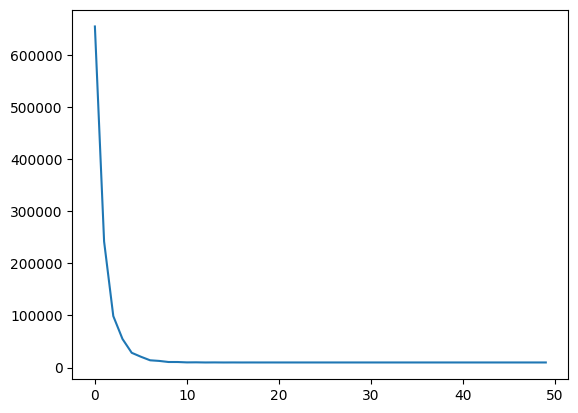

In [ ]:
import matplotlib.pyplot as plt

def loss(W, X, y):
  """
  W shape (d,)
  X shape (n, d)
  y shape (n,)
  """

  diff = y - X @ W.T
  return np.sum(diff**2)

def derivative(W, X, y):
  """
  W shape (d,)
  X shape (n, d)
  y shape (n,)
  """

  return -2 * X.T @ y + 2 * X.T @ X @ W + 2 * lambda_ * W


number_of_iterations = 50
learning_rate = 0.005

W = np.random.randn(d)

losses = np.zeros(number_of_iterations)
der = np.zeros(10)

# Gradient descent
for i in range(number_of_iterations):
  der = derivative(W, X, y)
  W = W - learning_rate * der
  losses[i] = loss(W, X, y)

plt.plot(np.arange(0, number_of_iterations), losses)

4. Compare your result with `scikit-learn`'s `Ridge` model.

In [ ]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=lambda_, fit_intercept=False)
model.fit(X, y)

print(f"Weights from analytical solution :\n { w_ridge_analytical.round(4) } " )
print(f"Weights from gradient descent :\n { W.round(4)}" )
print(f"Weights from scikit-learn :\n { model.coef_.round(4) } " )
print(f"Solutions are close (analytical vs scikit-learn) : { np.allclose( w_ridge_analytical , model.coef_ ) }" )
print(f"Solutions are close (analytical vs gradient) : { np.allclose( w_ridge_analytical , W ) }" )

Weights from analytical solution :
 [ 9.2857 54.8579  3.682  62.2875 92.0716 69.7765 84.7016  8.5026  3.9523
 69.7752  9.2857] 
Weights from gradient descent :
 [ 9.4276 54.8579  3.682  62.2875 92.0716 69.7765 84.7016  8.5026  3.9523
 69.7752  9.1439]
Weights from scikit-learn :
 [ 9.2857 54.8579  3.682  62.2875 92.0716 69.7765 84.7016  8.5026  3.9523
 69.7752  9.2857] 
Solutions are close (analytical vs scikit-learn) : True
Solutions are close (analytical vs gradient) : False


**Questions**:
1. Why must we set fit `intercept=False` in the `Ridge` model to get a perfect match with
the analytical formula provided?
2. What would happen to the analytical solution if $X^TX$ is not invertible (e.g., more features
than samples) and $\lambda = 0$? How does a small positive $\lambda$ fix this issue?

**Answers**:
1. In modeling stage, the zero-mean Normal distribution is selected, so the model set the mean (Offset) as zero. As a result, if `Ridge` tries to fit with offset, it will not match the weights learned from the model, which drawn from a zero-mean Normal distribution. But it will fit better to the biased data. (The analytical formula is drawn from the condition that $\mu$ is zero)
2. If $X^TX$ is not invertable and $\lambda = 0$ then the analitical solutiuon become $W = (X^TX)^{-1}X^Ty$ could not be solved. A small paositive $\lambda$ added to the diagonal position makes it always have positive eigenvalue and always invertable.
   * $X^TX$ is symmetric, so its eigenvalue are positive or zero.
   * $X^TX + {\lambda}I$ with positive small $\lambda$ makes it be $e_i + \lambda$ always positive, so then it always be invertable

## 2.2 Task 1.2: Visualizing the Effect of λ

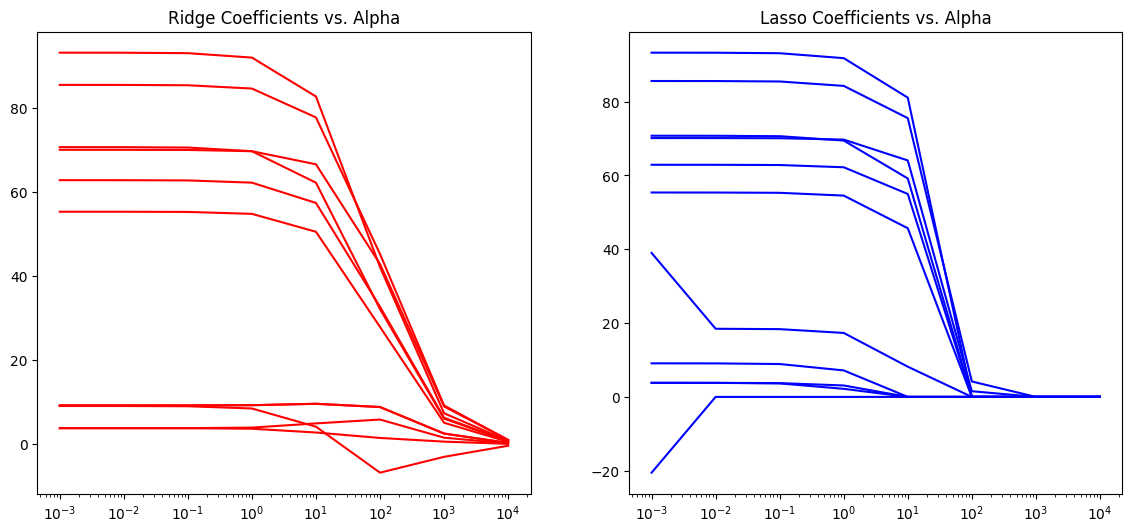

In [ ]:
from sklearn.linear_model import Ridge, Lasso
import matplotlib.pyplot as plt

alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]

coefficients = np.zeros((2, len(alphas), d))

for i in range(len(alphas)):
  ridge = Ridge(alpha=alphas[i], fit_intercept=False)
  ridge.fit(X, y)

  lasso = Lasso(alpha=alphas[i], fit_intercept=False)
  lasso.fit(X, y)

  coefficients[0, i] = ridge.coef_
  coefficients[1, i] = lasso.coef_

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for i in range(d):
  ax1.plot(alphas, coefficients[0, :, i], color='r')
  ax2.plot(alphas, coefficients[1, :, i], color='b')

ax1.set_title('Ridge Coefficients vs. Alpha')
ax1.set_xscale('log')

ax2.set_title('Lasso Coefficients vs. Alpha')
ax2.set_xscale('log')

**Questions**:
1. Looking at your Ridge coefficient plot, what is the general trend for all coefficients as
`alpha` increases?
2. Compare the Ridge and Lasso plots. What is the most significant difference in behavior, especially for large `alpha` values? Which method performs feature selection?

**Answers**:
1. While `alpha` becomes larger, the coefficients become smaller.
2. For large `alpha` value, in Ridge values become small but evenly distributed on a small range. However, in Lasso case the values are concentrated in relatively same spots, separated as large value and around zero.

## Task 2.1: Data Loading and Preprocessing

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/Hitters.csv")

df = df.dropna(subset=["Salary"])
X = pd.get_dummies(df.drop("Salary", axis = 1), drop_first=True)
y = df["Salary"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Question**:
* Why is it critical to fit the scaler only on the training data and then use it to
transform both the training and test sets?

**Answer**:
* If fit the scalar on test set, it means that the model already learned mean and variance of test set. test set should be unseed data.

In [ ]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error

alphas = np.logspace(-2, 4, 100)

ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train_scaled, y_train)

print(f"Best alpha fro Ridge: {ridge_cv.alpha_:.4f}")

lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)

print(f"Best alpha for Lasso: {lasso_cv.alpha_:.4f}")

ridge_pred = ridge_cv.predict(X_test_scaled)
lasso_pred = lasso_cv.predict(X_test_scaled)

print(f"Rdige Test MSE: {mean_squared_error(y_test, ridge_pred):.2f}")
print(f"Lasso Test MSE: {mean_squared_error(y_test, lasso_pred):.2f}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Best alpha fro Ridge: 132.1941
Best alpha for Lasso: 24.7708
Rdige Test MSE: 146744.70
Lasso Test MSE: 142996.09


## Task 2.3: Interpretation and Analysis

Lasso non-zero values count: 5


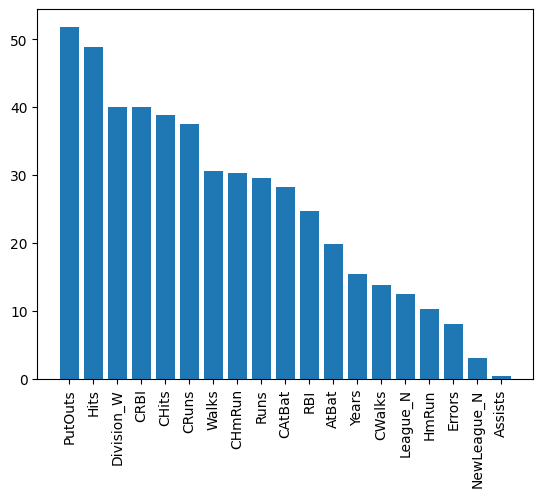

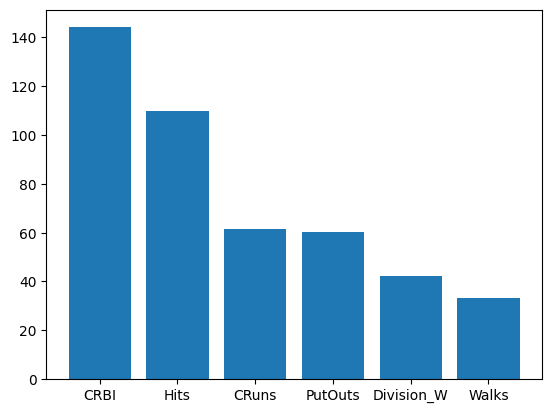

In [ ]:
import matplotlib.pyplot as plt

lasso_non_zero_coef_count = sum([1 for coef in lasso_cv.coef_ if coef > 0])

print(f"Lasso non-zero values count: {lasso_non_zero_coef_count}")

ridge_pairs = []
for i in range(len(ridge_cv.coef_)):
  absolute = abs(ridge_cv.coef_[i])
  if absolute > 0:
    ridge_pairs.append([X.columns[i], absolute])

sorted_coef = sorted(ridge_pairs, key=lambda i: i[1], reverse=True)
plt.bar([i[0] for i in sorted_coef], [i[1] for i in sorted_coef])
plt.xticks(rotation=90)
plt.show()


lasso_pairs = []
for i in range(len(lasso_cv.coef_)):
  absolute = abs(lasso_cv.coef_[i])
  if absolute > 0:
    lasso_pairs.append([X.columns[i], absolute])

sorted_coef = sorted(lasso_pairs, key=lambda i: i[1], reverse=True)
plt.bar([i[0] for i in sorted_coef], [i[1] for i in sorted_coef])
plt.show()